In [1]:
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Generate Data for 4-bit binary strings
N = 10
samples = [list(f"{i:0{N}b}") for i in range(2**N)]
X = np.array(samples, dtype=np.int32)
y = np.array([sum(map(float, sample)) % 2 for sample in samples])

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [3]:
# A network with two layers. The first layer has three neurons and the second layer has one neuron.
structure = [2, 1]

# Initialize the device with a dynamic number of wires
num_qubits = sum(structure) + 11  # 4(input qubit) + 1(label qubit)
dev = qml.device("default.qubit", wires=num_qubits)

In [4]:
def qn(paras, control_q, ancila):
    for i in range(len(control_q)):
        qml.CRY(paras[i], wires=[control_q[i], ancila])
    qml.RZ(paras[len(control_q)], ancila)
    qml.RY(paras[len(control_q)+1], ancila)

In [5]:
@qml.qnode(dev, interface="autograd")
def circuit(paras, f=None, label=1, structure=structure):
    gate_params = 1

    # Initial state
    if f is not None:
        qml.BasisState(f, wires=range(N))

    idx = 0
    ancila_start = N
    control_q = range(N) # input quibit

    for num_neurons in structure:
        new_control_q = []
        for _ in range(num_neurons):
            qn(paras[idx:idx+len(control_q)+gate_params+1], control_q, ancila_start)
            idx += len(control_q) + gate_params + 1
            new_control_q.append(ancila_start)
            ancila_start += 1
        control_q = new_control_q

    # Apply a Pauli-X gate if label is 1
    if label==1:
        qml.PauliX(wires=ancila_start)

    return qml.expval(qml.PauliZ(ancila_start - 1) @ qml.PauliZ(ancila_start))

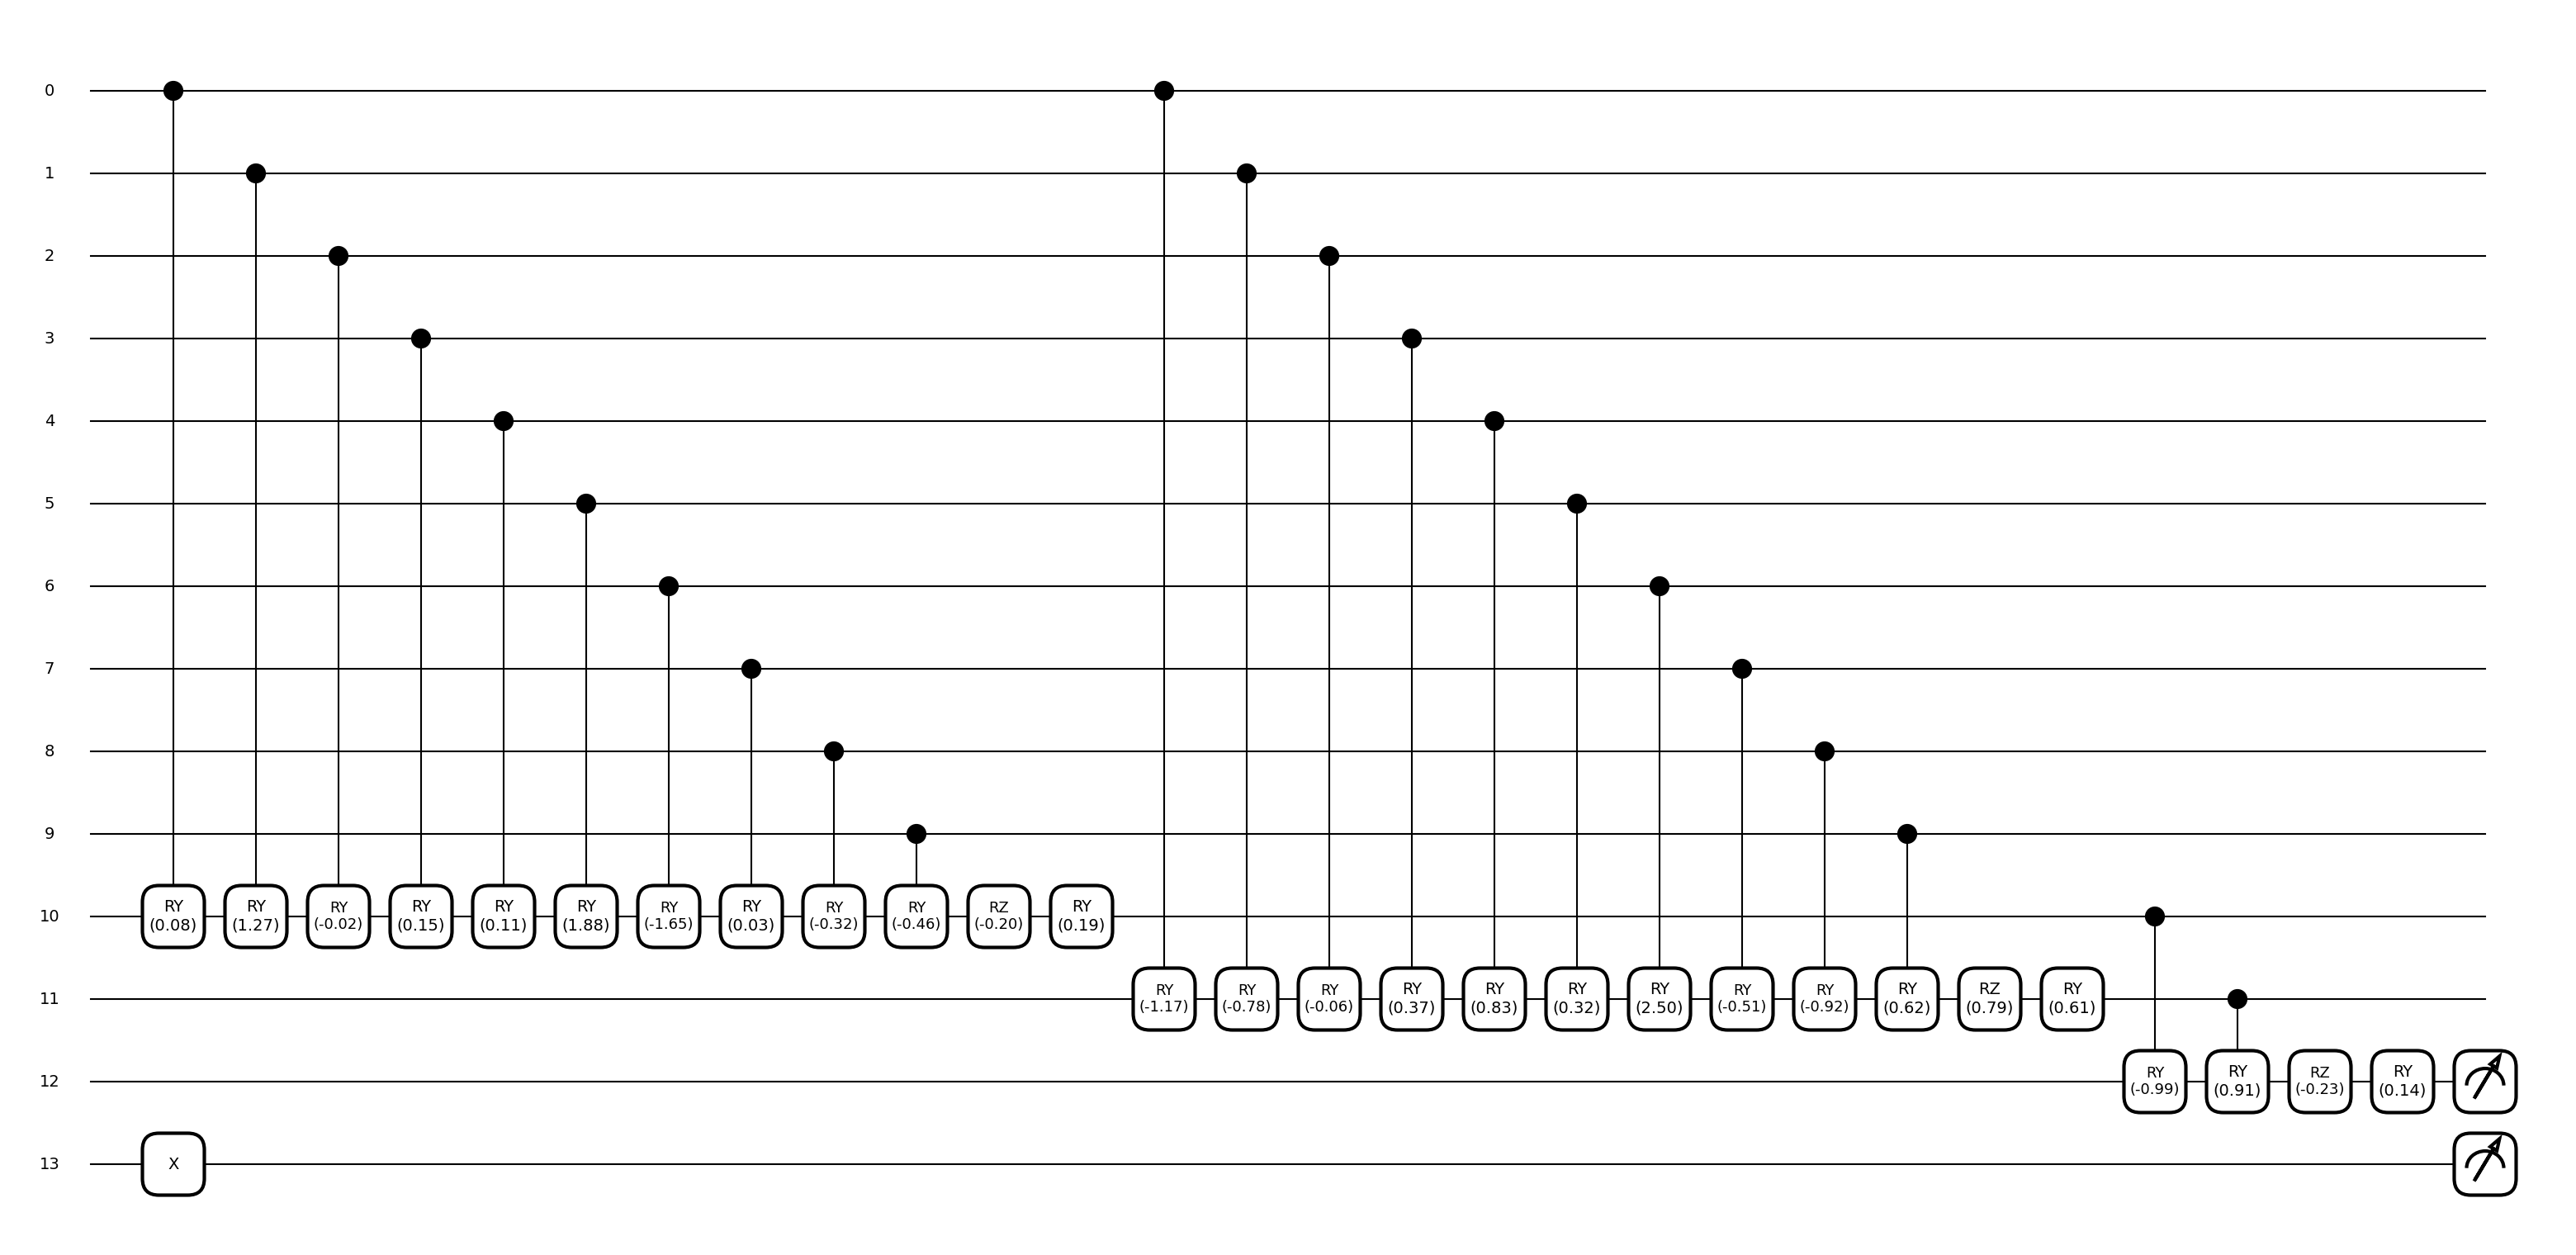

In [6]:
# Random initialization of parameters
paras_num = structure[0]*(N+2) + structure[1]*(structure[0]+2)
paras_init = np.random.randn(paras_num)

# Draw the executed quantum circuit:
fig, ax = qml.draw_mpl(circuit, decimals=2)(paras_init,
                                            label=1)
plt.show()

In [7]:
def sum_loss(predictions):
    loss = - (np.sum(predictions) / len(predictions))
    return loss

def accuracy(predictions):
    acc = 0
    for p in predictions:
        if p > 0:
            acc = acc + 1
    return acc / len(predictions)

def cost(paras, features, labels):
    predictions = [circuit(paras, f, label) for (f, label) in zip (features, labels)]
    return sum_loss(predictions)

In [8]:
# epoch作为衡量
opt = AdamOptimizer(0.05)
num_train = len(X_train)
num_epochs = 200
batch_size = 64

# train the variational classifier
paras = paras_init
cost_test_i, acc_test_i = [], []
cost_train_i, acc_train_i = [], []
num_batches = num_train // batch_size  # Determine number of batches

for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        # Compute start and end indices for batch
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        
    # If end index goes beyond the number of training samples, clip it
        if end_idx > num_train:
            end_idx = num_train
        
        X_train_batch = X_train[start_idx:end_idx]
        y_train_batch = y_train[start_idx:end_idx]
        #paras, _, _ = opt.step(cost, paras, feats_train_batch, Y_train_batch)
        paras = opt.step(lambda v: cost(v, X_train_batch, y_train_batch), paras)

    # Compute predictions on train and validation set
    predictions_train = [circuit(paras, f, label) for (f, label) in zip (X_train, y_train)]
    predictions_test = [circuit(paras, f, label) for (f, label) in zip (X_test, y_test)]
        
    # Compute accuracy on train and validation set
    acc_train = accuracy(predictions_train)
    acc_test = accuracy(predictions_test)
    acc_train_i.append(acc_train)
    acc_test_i.append(acc_test)

    cost_train = sum_loss(predictions_train)
    cost_test = sum_loss(predictions_test)
    cost_train_i.append(cost_train)
    cost_test_i.append(cost_test)
    print(
        "Iter: {:5d} | Cost train: {:0.7f} | Cost test: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
        "".format(epoch + 1, cost_train, cost_test, acc_train, acc_test)
    )

Iter:     1 | Cost train: -0.0130317 | Cost test: 0.0520674 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     2 | Cost train: -0.0154851 | Cost test: 0.0618645 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     3 | Cost train: -0.0172696 | Cost test: 0.0689950 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     4 | Cost train: -0.0194562 | Cost test: 0.0777293 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     5 | Cost train: -0.0217962 | Cost test: 0.0870765 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     6 | Cost train: -0.0244655 | Cost test: 0.0977421 | Acc train: 0.5079365 | Acc test: 0.4682927 
Iter:     7 | Cost train: -0.0275671 | Cost test: 0.1101335 | Acc train: 0.5177045 | Acc test: 0.4195122 
Iter:     8 | Cost train: -0.0308036 | Cost test: 0.1230609 | Acc train: 0.5299145 | Acc test: 0.3804878 
Iter:     9 | Cost train: -0.0337513 | Cost test: 0.1348257 | Acc train: 0.5311355 | Acc test: 0.3804878 
Iter:    10 | Cost train: -0.0362118 | Cost te

In [9]:
# Define Model
model = Sequential()
model.add(Dense(500, input_dim=N, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile Model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=Adam(lr=0.01), 
              metrics=['accuracy'])

/Users/wusixuan/opt/anaconda3/envs/py_pennylane/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Train Model on Training Data
history = model.fit(X_train,
                    y_train, 
                    epochs=200, 
                    verbose=2, 
                    validation_data=(X_test, y_test))

Epoch 1/200
26/26 - 1s - loss: 0.7175 - accuracy: 0.4847 - val_loss: 0.7031 - val_accuracy: 0.4488 - 587ms/epoch - 23ms/step
Epoch 2/200
26/26 - 0s - loss: 0.6945 - accuracy: 0.5067 - val_loss: 0.6983 - val_accuracy: 0.4049 - 63ms/epoch - 2ms/step
Epoch 3/200
26/26 - 0s - loss: 0.6940 - accuracy: 0.4969 - val_loss: 0.7012 - val_accuracy: 0.4098 - 67ms/epoch - 3ms/step
Epoch 4/200
26/26 - 0s - loss: 0.6929 - accuracy: 0.5006 - val_loss: 0.6980 - val_accuracy: 0.3610 - 64ms/epoch - 2ms/step
Epoch 5/200
26/26 - 0s - loss: 0.6926 - accuracy: 0.5043 - val_loss: 0.7016 - val_accuracy: 0.4195 - 67ms/epoch - 3ms/step
Epoch 6/200
26/26 - 0s - loss: 0.6940 - accuracy: 0.5116 - val_loss: 0.7045 - val_accuracy: 0.4537 - 65ms/epoch - 3ms/step
Epoch 7/200
26/26 - 0s - loss: 0.6939 - accuracy: 0.5067 - val_loss: 0.7033 - val_accuracy: 0.4683 - 65ms/epoch - 2ms/step
Epoch 8/200
26/26 - 0s - loss: 0.6933 - accuracy: 0.5079 - val_loss: 0.6985 - val_accuracy: 0.4683 - 61ms/epoch - 2ms/step
Epoch 9/200
26

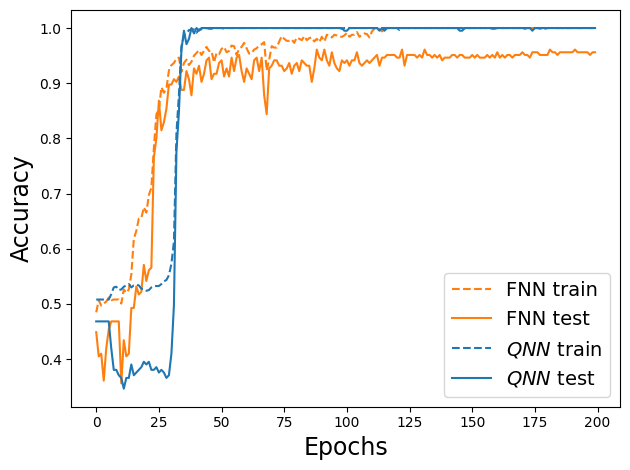

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], color='C1', linestyle='--')
plt.plot(history.history['val_accuracy'], color='C1')
plt.plot(acc_train_i, color='C0', linestyle='--')
plt.plot(acc_test_i, color='C0')
plt.ylabel('Accuracy', fontsize=17)
plt.xlabel('Epochs', fontsize=17)
plt.legend(['FNN train', 'FNN test', '$QNN$ train', '$QNN$ test'], fontsize=14)

plt.tight_layout()
plt.show()